Quoting the description:

> This algorithm finds the most unexpected events in a set of geographic events relative to some reference set of events

<img src="Screenshot1.png" />

This looks like an algorithm that could be very useful for fraud detection.  If I map all transactions to the location at which they happen, I can then check if a new location would be considered an outlier.  If so, that doesn't mean it's fraud, but it's potentially a useful feature.

In [187]:
# Importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import Algorithmia
import numpy as np
import xmltodict, json
import os
import ConfigParser

In [188]:
# Loading up my config (provide your own creds) and getting the algo
propertiesFile = "my.properties"
cp = ConfigParser.ConfigParser()
cp.readfp(open(propertiesFile))

client_key = cp.get('algorithmia', 'client')

client = Algorithmia.client(client_key)
algo = client.algo('sklearn/GeographicOutlierDetection/0.2.5')

In [191]:
# Let's do a quick test
# `reference` is considered to be typical dat
# `data` is the new tracked points we are curious about
data = [[47.625401388, -122.341846999], [47.627424837, -122.339708605]]
reference = [[47.610975162999999, -122.33814674799999], [47.610440244999999, -122.33689051499999]]

In [192]:
# Here is what the results look like
input = {"data": data, "reference": reference, "n": 3}
resp = algo.pipe(input)
print resp

AlgoResponse(result={u'logprobs': {u'1': 4.527756077683622, u'0': 4.511270356968919}, u'outliers': [1, 0], u'all_lp': [4.527756077683622, 4.511270356968919]},metadata=Metadata(content_type='json',duration=0.334284102,stdout=None))


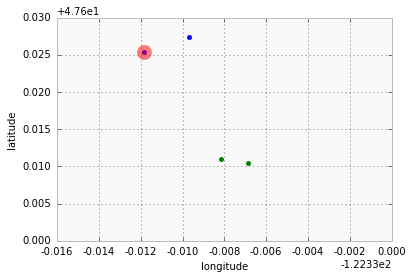

In [193]:
# Now we plot the results on this toy example and put a red circle on the outlier

references = input['reference']
data = input['data']
outliers = resp.result['outliers']

lats = []
lons = []
for reference in references:
    lats.append(reference[0])
    lons.append(reference[1])

plt.scatter(lons, lats, color='green')


lats = []
lons = []
for reference in data:
    lats.append(reference[0])
    lons.append(reference[1])

plt.scatter(lons, lats, color='blue')

filter = np.array(data[0]) * np.array(outliers) > 0
plt.scatter(np.array(lons)[filter], np.array(lats)[filter], color='red', alpha=0.5, s=200)

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

Now on to some real data.  I tracked my own location via an app on my phone for about a month.  Let's load up that data and plot it to see what it looks like.

In [194]:
lats = []
lngs = []
traces = os.listdir('lltrace')
for trace in traces:
    f = open('lltrace/' + trace, 'r')
    s = f.read()
    f.close()
    o = xmltodict.parse(s)
    tracks = o['gpx']['trk']['trkseg']['trkpt']
    for track in tracks:
        lats.append(track['@lat'])
        lngs.append(track['@lon'])

In [195]:
lats = map(lambda x: float(x), lats)
lngs = map(lambda x: float(x), lngs)

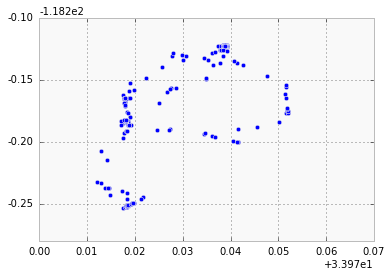

In [196]:
plt.scatter(lats, lngs)
plt.show()

Ok, cool, looks like I got around to a lot of places during this time period!

In [199]:
trace = []
for i in range(len(lats)):
    trace.append([lats[i], lngs[i]])

In [200]:
# This creates a grid of theoretical new datapoints.
# Let's see which are considered outliers!

test = []
lat_min = min(lats)
lng_min = min(lngs)
lat_max = max(lats)
lng_max = max(lngs)
lat_span = lat_max - lat_min
lng_span = lng_max - lng_min
n = 25
for i in range(n):
    lat = lat_min + 1.0 * i / n * lat_span
    for j in range(n):
        lng = lng_min + 1.0 * j / n * lng_span
        test.append([lat, lng])

In [201]:
# Call the model to find out

input = {"data": test, "reference": trace, "n": n}
client = Algorithmia.client('sime9LW7bScBtTy8eag15oGxNKc1')
algo = client.algo('sklearn/GeographicOutlierDetection/0.2.5')
resp = algo.pipe(input)

outliers = resp.result['outliers']
olls = []
for i in range(len(outliers)):
    olls.append(test[outliers[i]])

olls = zip(*olls)

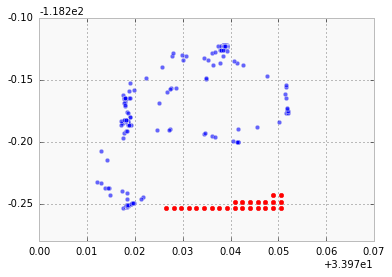

In [202]:
# Let's plot the actual data in blue, and then
# the grid points marked as outliers in red.
plt.scatter(lats, lngs, alpha=.6)
plt.scatter(olls[0], olls[1], color='red')

Ok, here we can see for the given n selected, the points considered outliers are in one area.  Let's expand the sensitivity and see if we can learn more about how the algorithm is working.

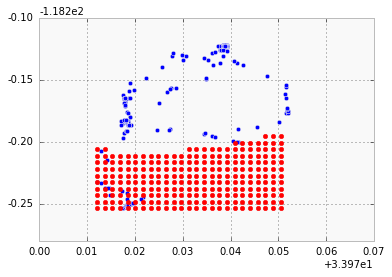

In [203]:
input = {"data": test, "reference": trace, "n": 250}
client = Algorithmia.client('sime9LW7bScBtTy8eag15oGxNKc1')
algo = client.algo('sklearn/GeographicOutlierDetection/0.2.5')
resp = algo.pipe(input)

outliers = resp.result['outliers']
olls = []
for i in range(len(outliers)):
    olls.append(test[outliers[i]])

olls = zip(*olls)

plt.scatter(lats, lngs)
plt.scatter(olls[0], olls[1], color='red')
plt.show()

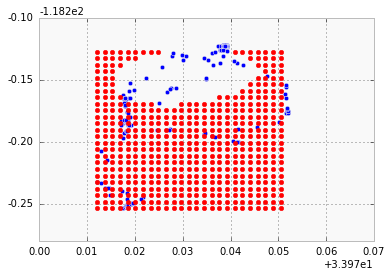

In [204]:
input = {"data": test, "reference": trace, "n": 500}
client = Algorithmia.client('sime9LW7bScBtTy8eag15oGxNKc1')
algo = client.algo('sklearn/GeographicOutlierDetection/0.2.5')
resp = algo.pipe(input)

outliers = resp.result['outliers']
olls = []
for i in range(len(outliers)):
    olls.append(test[outliers[i]])

olls = zip(*olls)

plt.scatter(lats, lngs)
plt.scatter(olls[0], olls[1], color='red')
plt.show()

Ah ha!  It appears there's some sort of centroid based approach.  Let's try two commonly used clustering algorithms and see if we can figure out that it's using a particular off the shelf technique.

In [205]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [210]:
colormap = np.array(['r', 'b', 'g', 'orange', 'i', 'v', 'y'])

In [211]:
X = StandardScaler().fit_transform(trace)
dbscan = DBSCAN(eps=.8, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

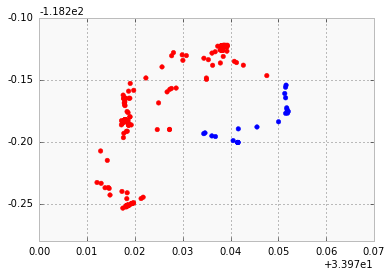

In [212]:
plt.scatter(lats, lngs, color=colormap[labels])
plt.show()

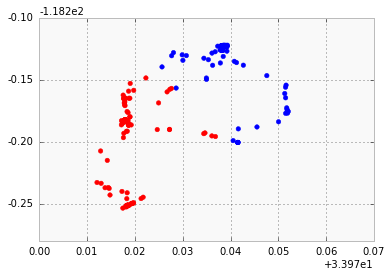

In [213]:
km = KMeans(n_clusters=2).fit(X)
labels = km.labels_
plt.scatter(lats, lngs, color=colormap[labels])
plt.show()

So I wasn't able to perfectly reverse engineer how this model works.  In truth, I know that the source is available, so I could just go look at it.  But I can't aways do that with any model I'm interested in, so this is meant to demo how I might approach the reverse engineering.